## Calcul de magnitude Mlv

Par application d'une déconvolution et reconvolution par un sismomètre de type Wood-Anderson

Voir : https://docs.gempa.de/seiscomp3/current/apps/global_mlv.html

Valable uniquement pour des distance séisme-station inférieur à 1000km

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from obspy import read, read_inventory, UTCDateTime, Stream
from obspy.clients.fdsn import Client
from obspy.geodetics.base import gps2dist_azimuth
from obspy.signal.invsim import estimate_wood_anderson_amplitude_using_response

%matplotlib inline

### Définition du séisme étudié

In [2]:
starttime = UTCDateTime(2021,6,26,3,0,0)
duration = 3*60
evla, evlo = 48.66, 7.82
staname = 'HOHE'

### Récupération données 

In [3]:
client = Client("RESIF") # Réseau français
INV = client.get_stations(network="FR", station=staname, location="00", channel="HHZ", starttime=starttime, level="response")
Z = client.get_waveforms(network="FR", station=staname, location="00", channel="HHZ", starttime=starttime, endtime=starttime + duration)
Z = Z.merge()[0]
Z.attach_response(INV)

/Users/jvergne/anaconda/envs/py35/lib/python3.5/site-packages/obspy/io/stationxml/core.py:84: UserWarning: The StationXML file has version 1.1, ObsPy can deal with version 1.0. Proceed with caution.
  root.attrib["schemaVersion"], SCHEMA_VERSION))


### Déconvolution / convolution par un sismomètre de type Wood-Anderson
Ci dessous :
1. Représentation de la donnée brute. L'échelle verticale est en count
2. Retrait de la réponse intrumentale. L'échelle verticale est en m/s
3. Convolution avec la réponse théorique d'un Wood-Anderson. L'échelle verticlae est en m

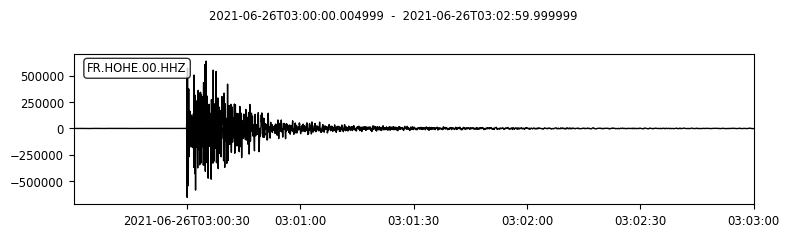

In [4]:
Z.plot()

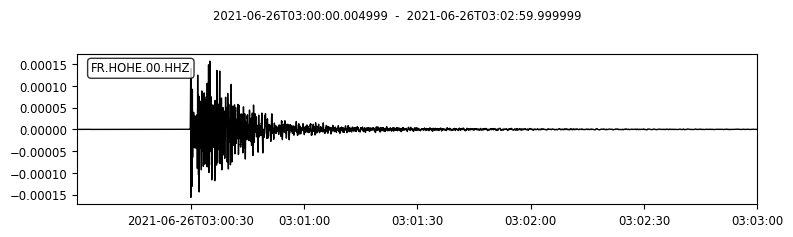

In [5]:
Z.remove_response()
Z.plot()

/Users/jvergne/anaconda/envs/py35/lib/python3.5/site-packages/obspy/signal/detrend.py:31: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(data.dtype, float):


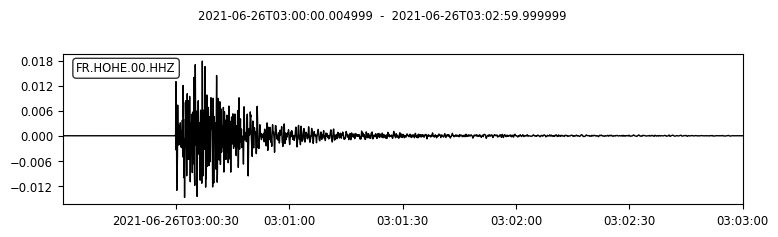

In [6]:
paz_wa = {'sensitivity': 2800, 'zeros': [0j], 'gain': 1,
          'poles': [-6.2832 - 4.7124j, -6.2832 + 4.7124j]}
Z.simulate(paz_simulate=paz_wa)
Z.plot()

### Mesure de la magnitude

#### Mesure de l'amplitude max. 
Multiplié x2 pour pic à pic (approximation) puis multiplié x1000 pour passer en mm

In [7]:
amp_pp = 2* np.max(np.abs(Z.data)) * 1000
print('amplitude pic à pic (mm) : ',amp_pp)

amplitude pic à pic (mm) :  35.814907193947505


#### Calcul de la distance séisme - station
en km (gps2dist_azimuth renvoit une valeur en m)

In [8]:
stla, stlo = INV[0][0].latitude, INV[0][0].longitude
d, az, baz = gps2dist_azimuth(stla,stlo,evla,evlo)
d = d/1000
print(d)

24.730920314207772


#### Calcul du facteur de correction A0
Voir https://docs.gempa.de/seiscomp3/current/apps/global_mlv.html

In [9]:
dA0 = np.array((0,60,400,1000))
aA0 =  np.array((-1.3,-2.8,-4.5,-5.85))
A0 = np.interp(d,dA0,aA0)
print(A0)

-1.9182730078551944


#### Calcul de la magnitude
Voir https://docs.gempa.de/seiscomp3/current/apps/global_mlv.html

In [10]:
Mlv = np.log10(amp_pp) - A0
print(Mlv)

3.472336837977541
